# Workflow for a district optimization

In this application of the FINE framework, a small district is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
from getData import getData
import pandas as pd

data = getData()

%load_ext autoreload
%autoreload 2
%matplotlib inline

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = data["locations"]
commodityUnitDict = {"electricity": "kW_el", "methane": "kW_CH4_LHV", "heat": "kW_th"}
commodities = {"electricity", "methane", "heat"}
numberOfTimeSteps = 8760
hoursPerTimeStep = 1

In [3]:
esM = fn.EnergySystemModel(
    locations=locations,
    commodities=commodities,
    numberOfTimeSteps=8760,
    commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=1,
    costUnit="€",
    lengthUnit="m",
    verboseLogLevel=2,
)

# 3. Add commodity sources to the energy system model

### Electricity Purchase

In [4]:
esM.add(
    fn.Source(
        esM=esM,
        name="Electricity purchase",
        commodity="electricity",
        hasCapacityVariable=False,
        operationRateMax=data["El Purchase, operationRateMax"],
        commodityCost=0.298,
    )
)

### Natural Gas Purchase

In [5]:
esM.add(
    fn.Source(
        esM=esM,
        name="NaturalGas purchase",
        commodity="methane",
        hasCapacityVariable=False,
        operationRateMax=data["NG Purchase, operationRateMax"],
        commodityCost=0.065,
    )
)

### PV

In [6]:
esM.add(
    fn.Source(
        esM=esM,
        name="PV",
        commodity="electricity",
        hasCapacityVariable=True,
        hasIsBuiltBinaryVariable=True,
        operationRateMax=data["PV, operationRateMax"],
        capacityMax=data["PV, capacityMax"],
        interestRate=0.04,
        economicLifetime=20,
        investIfBuilt=1000,
        investPerCapacity=1400,
        opexIfBuilt=10,
        bigM=40,
    )
)

# 4. Add conversion components to the energy system model

### Boiler

In [7]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="Boiler",
        physicalUnit="kW_th",
        commodityConversionFactors={"methane": -1.1, "heat": 1},
        hasIsBuiltBinaryVariable=True,
        hasCapacityVariable=True,
        interestRate=0.04,
        economicLifetime=20,
        investIfBuilt=2800,
        investPerCapacity=100,
        opexIfBuilt=24,
        bigM=200,
    )
)

# 5. Add commodity storages to the energy system model

### Thermal Storage 

In [8]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Thermal Storage",
        commodity="heat",
        selfDischarge=0.001,
        hasIsBuiltBinaryVariable=True,
        capacityMax=data["TS, capacityMax"],
        interestRate=0.04,
        economicLifetime=25,
        investIfBuilt=23,
        investPerCapacity=24,
        bigM=250,
    )
)

### Battery Storage

In [9]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Battery Storage",
        commodity="electricity",
        cyclicLifetime=10000,
        chargeEfficiency=0.95,
        dischargeEfficiency=0.95,
        chargeRate=0.5,
        dischargeRate=0.5,
        hasIsBuiltBinaryVariable=True,
        capacityMax=data["BS, capacityMax"],
        interestRate=0.04,
        economicLifetime=12,
        investIfBuilt=2000,
        investPerCapacity=700,
        bigM=110,
    )
)

# 6. Add commodity transmission components to the energy system model

### Cable Electricty

In [10]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="E_Distribution_Grid",
        commodity="electricity",
        losses=0.00001,
        distances=data["cables, distances"],
        capacityFix=data["cables, capacityFix"],
    )
)

### Natural Gas Pipeline

In [11]:
esM.add(
    fn.Transmission(
        esM=esM,
        name="NG_Distribution_Grid",
        commodity="methane",
        distances=data["NG, distances"],
        capacityFix=data["NG, capacityFix"],
    )
)

# 7. Add commodity sinks to the energy system model

### Electricity Demand

In [12]:
esM.add(
    fn.Sink(
        esM=esM,
        name="Electricity demand",
        commodity="electricity",
        hasCapacityVariable=False,
        operationRateFix=data["Electricity demand, operationRateFix"],
    )
)

### Heat Demand

In [13]:
esM.add(
    fn.Sink(
        esM=esM,
        name="BuildingsHeat",
        commodity="heat",
        hasCapacityVariable=False,
        operationRateFix=data["Heat demand, operationRateFix"],
    )
)

# 8. Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [14]:
esM.cluster(numberOfTypicalPeriods=7)

In [15]:
# esM.optimize(timeSeriesAggregation=True, optimizationSpecs='cuts=0 method=2')
esM.optimize(timeSeriesAggregation=True, solver="glpk")

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\K7BCD~1.KNO\AppData\Local\Temp\tmpuwjblbh1.glpk.raw --wglp
 C:\Users\K7BCD~1.KNO\AppData\Local\Temp\tmp3y_zjbde.glpk.glp --cpxlp C:\Users\K7BCD~1.KNO\AppData\Local\Temp\tmpad14hy51.pyomo.lp
Reading problem data from 'C:\Users\K7BCD~1.KNO\AppData\Local\Temp\tmpad14hy51.pyomo.lp'...
C:\Users\K7BCD~1.KNO\AppData\Local\Temp\tmpad14hy51.pyomo.lp:285901: warning: lower bound of variable 'x13' redefined
C:\Users\K7BCD~1.KNO\AppData\Local\Temp\tmpad14hy51.pyomo.lp:285901: warning: upper bound of variable 'x13' redefined
45047 rows, 25341 columns, 125011 non-zeros
32 integer variables, all of which are binary
285933 lines were read
Writing problem data to 'C:\Users\K7BCD~1.KNO\AppData\Local\Temp\tmp3y_zjbde.glpk.glp'...
251977 lines were written
GLPK Integer Optimizer, v4.65
45047 rows, 25341 columns, 125011 non-zeros
32 integer variables, all of which are binary
Preprocessing...
12 constraint coeffi

# 9. Selected results output

### Sources and Sink

In [16]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

bd1          bd2  \
Component            Property     Unit                                     
BuildingsHeat        operation    [kW_th*h/a]        213008       211961   
                                  [kW_th*h]          213008       211961   
Electricity demand   operation    [kW_el*h/a]         24719      19409.3   
                                  [kW_el*h]           24719      19409.3   
Electricity purchase TAC          [€/a]                   0            0   
                     commodCosts  [€/a]                 NaN          NaN   
                     operation    [kW_el*h/a]           NaN          NaN   
                                  [kW_el*h]             NaN          NaN   
NaturalGas purchase  TAC          [€/a]                   0            0   
                     commodCosts  [€/a]                 NaN          NaN   
                     operation    [kW_CH4_LHV*h/a]      NaN          NaN   
                                  [kW_CH4_LHV*h]        NaN          NaN   
PV                   TAC          [€/a]              1926.4  5.02692e-10   
                     capacity     [kW_el]           17.8889  4.87982e-12   
                     capexCap     [€/a]             1842.82  5.02692e-10   
                     capexIfBuilt [€/a]             73.5818            0   
                     invest       [€]               26044.5  6.83174e-09   
                     isBuilt      [-]                     1            0   
                     operation    [kW_el*h/a]       11753.3  2.13341e-09   
                                  [kW_el*h]         11753.3  2.13341e-09   
                     opexIfBuilt  [€/a]                  10            0   

                                                        bd3      bd4     bd5  \
Component            Property     Unit                                         
BuildingsHeat        operation    [kW_th*h/a]        212160   212865  212988   
                                  [kW_th*h]          212160   212865  212988   
Electricity demand   operation    [kW_el*h/a]       24892.8  17439.8   23310   
                                  [kW_el*h]         24892.8  17439.8   23310   
Electricity purchase TAC          [€/a]                   0        0       0   
                     commodCosts  [€/a]                 NaN      NaN     NaN   
                     operation    [kW_el*h/a]           NaN      NaN     NaN   
                                  [kW_el*h]             NaN      NaN     NaN   
NaturalGas purchase  TAC          [€/a]                   0        0       0   
                     commodCosts  [€/a]                 NaN      NaN     NaN   
                     operation    [kW_CH4_LHV*h/a]      NaN      NaN     NaN   
                                  [kW_CH4_LHV*h]        NaN      NaN     NaN   
PV                   TAC          [€/a]             1863.36        0       0   
                     capacity     [kW_el]            17.277        0       0   
                     capexCap     [€/a]             1779.78        0       0   
                     capexIfBuilt [€/a]             73.5818        0       0   
                     invest       [€]               25187.8        0       0   
                     isBuilt      [-]                     1        0       0   
                     operation    [kW_el*h/a]       13465.4        0       0   
                                  [kW_el*h]         13465.4        0       0   
                     opexIfBuilt  [€/a]                  10        0       0   

                                                        bd6 grid1 grid2 grid3  \
Component            Property     Unit                                          
BuildingsHeat        operation    [kW_th*h/a]        213361   NaN   NaN   NaN   
                                  [kW_th*h]          213361   NaN   NaN   NaN   
Electricity demand   operation    [kW_el*h/a]       19718.3   NaN   NaN   NaN   
                                  [kW_el*h]         19718.3  

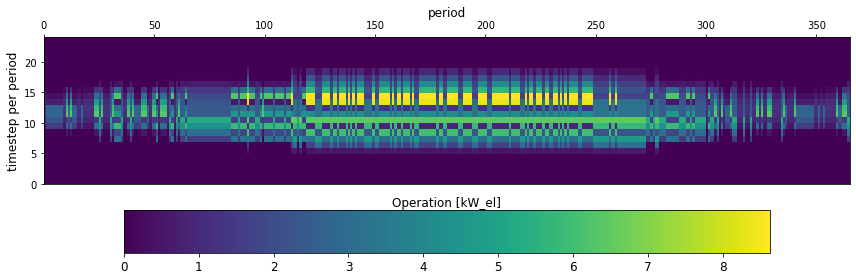

In [17]:
fig, ax = fn.plotOperationColorMap(esM, "PV", "bd1")

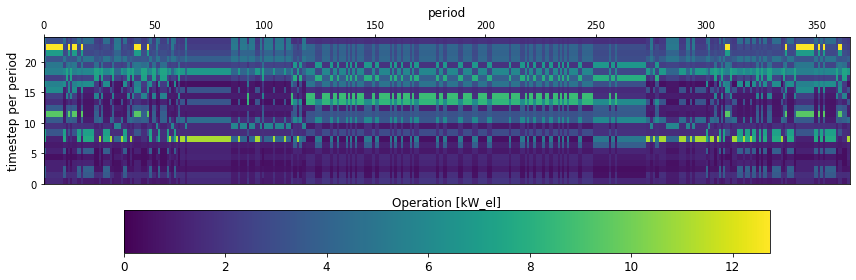

In [18]:
fig, ax = fn.plotOperationColorMap(esM, "Electricity demand", "bd1")

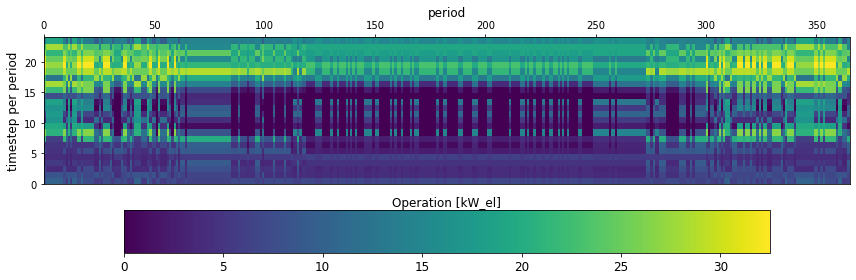

In [19]:
fig, ax = fn.plotOperationColorMap(esM, "Electricity purchase", "transformer")

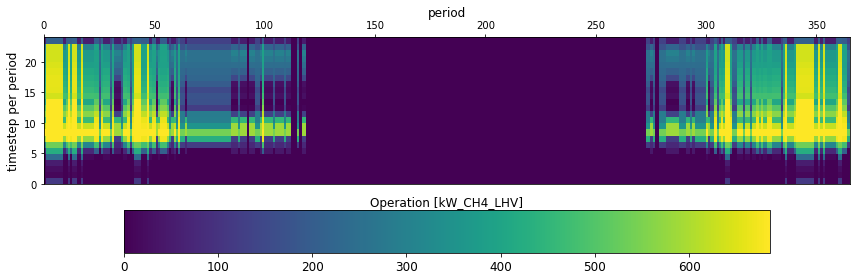

In [20]:
fig, ax = fn.plotOperationColorMap(esM, "NaturalGas purchase", "transformer")

### Conversion

In [21]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

bd1      bd2      bd3      bd4  \
Component Property     Unit                                              
Boiler    TAC          [€/a]        902.759  1003.31  960.287  1101.52   
          capacity     [kW_th]      91.4262  105.092  99.2445  118.438   
          capexCap     [€/a]         672.73  773.282  730.258  871.489   
          capexIfBuilt [€/a]        206.029  206.029  206.029  206.029   
          invest       [€]          11942.6  13309.2  12724.5  14643.8   
          isBuilt      [-]                1        1        1        1   
          operation    [kW_th*h/a]   213031   211993   212188   212878   
                       [kW_th*h]     213031   211993   212188   212878   
          opexIfBuilt  [€/a]             24       24       24       24   

                                        bd5      bd6 grid1 grid2 grid3 grid4  \
Component Property     Unit                                                    
Boiler    TAC          [€/a]        1017.92  979.634     0     0     0     0   
          capacity     [kW_th]      107.077  101.874     0     0     0     0   
          capexCap     [€/a]        787.889  749.605     0     0     0     0   
          capexIfBuilt [€/a]        206.029  206.029     0     0     0     0   
          invest       [€]          13507.7  12987.4     0     0     0     0   
          isBuilt      [-]                1        1     0     0     0     0   
          operation    [kW_th*h/a]   213002   213380     0     0     0     0   
                       [kW_th*h]     213002   213380     0     0     0     0   
          opexIfBuilt  [€/a]             24       24     0     0     0     0   

                                   grid5 grid6 grid7 transformer  
Component Property     Unit                                       
Boiler    TAC          [€/a]           0     0     0           0  
          capacity     [kW_th]         0     0     0           0  
          capexCap     [€/a]           0     0     0           0  
          capexIfBuilt [€/a]           0     0     0           0  
          invest       [€]             0     0     0           0  
          isBuilt      [-]             0     0     0           0  
          operation    [kW_th*h/a]     0     0     0           0  
                       [kW_th*h]       0     0     0           0  
          opexIfBuilt  [€/a]           0     0     0           0

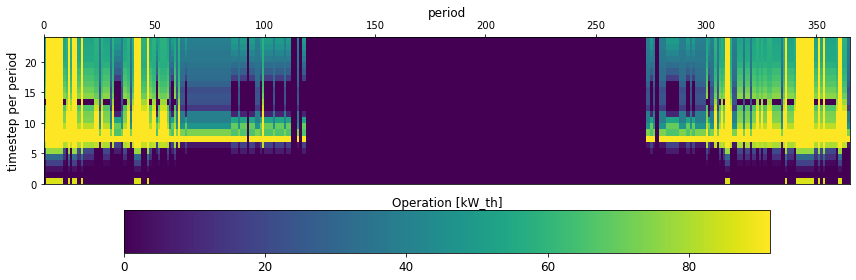

In [22]:
fig, ax = fn.plotOperationColorMap(esM, "Boiler", "bd1")

### Storage

In [23]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

bd1          bd2  \
Component       Property           Unit                                    
Battery Storage TAC                [€/a]                  0            0   
                capacity           [kW_el*h]              0            0   
                capexCap           [€/a]                  0            0   
                invest             [€]                    0            0   
                operationCharge    [kW_el*h/a] -2.09423e-12  1.10367e-10   
                                   [kW_el*h]   -2.09423e-12  1.10367e-10   
                operationDischarge [kW_el*h/a] -3.68342e-12  8.93441e-11   
                                   [kW_el*h]   -3.68342e-12  8.93441e-11   
Thermal Storage TAC                [€/a]            186.247      287.596   
                capacity           [kW_th*h]        120.273      186.244   
                capexCap           [€/a]            184.775      286.123   
                capexIfBuilt       [€/a]            1.47228      1.47228   
                invest             [€]              2909.56      4492.84   
                isBuilt            [-]                    1            1   
                operationCharge    [kW_th*h/a]      20607.4      10509.4   
                                   [kW_th*h]        20607.4      10509.4   
                operationDischarge [kW_th*h/a]      20585.1      10478.1   
                                   [kW_th*h]        20585.1      10478.1   

                                                        bd3          bd4  \
Component       Property           Unit                                    
Battery Storage TAC                [€/a]                  0 -1.59945e-12   
                capacity           [kW_el*h]              0 -2.14443e-14   
                capexCap           [€/a]                  0 -1.59945e-12   
                invest             [€]                    0  -1.5011e-11   
                operationCharge    [kW_el*h/a]   -4.573e-12 -3.36849e-11   
                                   [kW_el*h]     -4.573e-12 -3.36849e-11   
                operationDischarge [kW_el*h/a] -3.41508e-12 -3.08436e-11   
                                   [kW_el*h]   -3.41508e-12 -3.08436e-11   
Thermal Storage TAC                [€/a]            239.629      203.143   
                capacity           [kW_th*h]        155.021      131.272   
                capexCap           [€/a]            238.157      201.671   
                capexIfBuilt       [€/a]            1.47228      1.47228   
                invest             [€]              3743.51      3173.52   
                isBuilt            [-]                    1            1   
                operationCharge    [kW_th*h/a]      11329.9      6040.31   
                                   [kW_th*h]        11329.9      6040.31   
                operationDischarge [kW_th*h/a]      11301.8      6027.41   
                                   [kW_th*h]        11301.8      6027.41   

                                                        bd5          bd6  \
Component       Property           Unit                                    
Battery Storage TAC                [€/a]         2.6209e-12            0   
                capacity           [kW_el*h]    3.51391e-14            0   
                capexCap           [€/a]         2.6209e-12            0   
                invest             [€]          2.45973e-11            0   
                operationCharge    [kW_el*h/a]  4.53949e-11 -8.52651e-11   
                                   [kW_el*h]    4.53949e-11 -8.52651e-11   
                operationDischarge [kW_el*h/a]  3.99557e-11 -8.13934e-11   
                                   [kW_el*h]    3.99557e-11 -8.13934e-11   
Thermal Storage TAC                [€/a]            160.089      277.432   
                capacity           [kW_th*h]        103.247      179.628   
                capexCap           [€/a]            158.616       275.96   
                capexIfBui

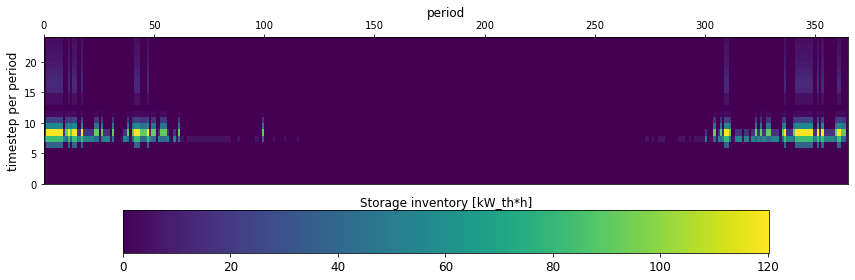

In [24]:
fig, ax = fn.plotOperationColorMap(
    esM, "Thermal Storage", "bd1", variableName="stateOfChargeOperationVariablesOptimum"
)

### Transmission

In [25]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

bd1  bd2  bd3  \
Component            Property  Unit           LocationIn                   
E_Distribution_Grid  capacity  [kW_el]        bd1          NaN  NaN  NaN   
                                              bd2          NaN  NaN  NaN   
                                              bd3          NaN  NaN  NaN   
                                              bd4          NaN  NaN  NaN   
                                              bd5          NaN  NaN  NaN   
...                                                        ...  ...  ...   
NG_Distribution_Grid operation [kW_CH4_LHV*h] grid4        NaN  NaN  NaN   
                                              grid5        NaN  NaN  NaN   
                                              grid6        NaN  NaN  NaN   
                                              grid7        NaN  NaN  NaN   
                                              transformer  NaN  NaN  NaN   

                                                              bd4     bd5  \
Component            Property  Unit           LocationIn                    
E_Distribution_Grid  capacity  [kW_el]        bd1             NaN     NaN   
                                              bd2             NaN     NaN   
                                              bd3             NaN     NaN   
                                              bd4             NaN     NaN   
                                              bd5             NaN     NaN   
...                                                           ...     ...   
NG_Distribution_Grid operation [kW_CH4_LHV*h] grid4           NaN     NaN   
                                              grid5        234166     NaN   
                                              grid6           NaN  234302   
                                              grid7           NaN     NaN   
                                              transformer     NaN     NaN   

                                                              bd6  \
Component            Property  Unit           LocationIn            
E_Distribution_Grid  capacity  [kW_el]        bd1             NaN   
                                              bd2             NaN   
                                              bd3             NaN   
                                              bd4             NaN   
                                              bd5             NaN   
...                                                           ...   
NG_Distribution_Grid operation [kW_CH4_LHV*h] grid4           NaN   
                                              grid5           NaN   
                                              grid6           NaN   
                                              grid7        234718   
                                              transformer     NaN   

                                                                 grid1  grid2  \
Component            Property  Unit           LocationIn                        
E_Distribution_Grid  capacity  [kW_el]        bd1                10000    NaN   
                                              bd2                  NaN  10000   
                                              bd3                  NaN    NaN   
                                              bd4                  NaN    NaN   
                                              bd5                  NaN    NaN   
...                                                                ...    ...   
NG_Distribution_Grid operation [kW_CH4_LHV*h] grid4                NaN    NaN   
                                              grid5                NaN    NaN   
                                              grid6                NaN    NaN   
                                              grid7                NaN    NaN   
                                              transformer  1.40412e+06    NaN   

                                                                 grid3  \
Component            Property  Unit       